Load Libs

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from matplotlib import pyplot as plt
import pickle
from sklearn.neighbors import KNeighborsClassifier as KNNC
from sklearn.tree import DecisionTreeClassifier as DST
from Gen_diffrent_classifier import *
%matplotlib inline

Load Data

In [2]:
with open('test.pkl','rb') as fl:
    test = pickle.load(fl)

In [3]:
with open('validation.pkl','rb') as fl:
    validation = pickle.load(fl)

with open('test.pkl','rb') as fl:
    test = pickle.load(fl)

dataset = pd.DataFrame.from_csv('featured_data.csv')
train = pd.concat([dataset, test, validation]).drop_duplicates(keep=False)

### Without Genetic

In [4]:
label_test = np.asanyarray(test.ix[:, test.columns == 'class'])

In [5]:
KNNC_model = KNNC()

KNNC_model.fit(validation.ix[:, train.columns != 'class'],validation.ix[:, train.columns == 'class'])

KNNC_model.score(test.ix[:,train.columns != 'class'],test.ix[:, test.columns == 'class'])

pred_KNNC = KNNC_model.predict(test.ix[:,train.columns != 'class'])

### Percision

label_test = np.asanyarray(label_test)
TP = np.sum(pred_KNNC== label_test)
FP = np.sum(label_test[np.where(label_test == 'Neg')[0]] != \
            pred_KNNC[np.where(label_test == 'Neg')[0]])
Precision = np.float(TP) / (np.float(TP) + np.float(FP))

print("Precision = ",Precision)

### Recal

FN = np.sum(np.not_equal(
                            label_test[np.where(label_test == 'Pos')[0]],
                            pred_KNNC[np.where(label_test == 'Pos')[0]]))
Recal = np.float(TP) / (np.float(TP) + np.float(FN))

print("Recal = ",Recal)

/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  app.launch_new_instance()


Precision =  0.9942857142857143
Recal =  0.7236084452975048


In [6]:
DST_model = DST()

DST_model.fit(validation.ix[:, train.columns != 'class'],validation.ix[:, train.columns == 'class'])

DST_model.score(test.ix[:,train.columns != 'class'],test.ix[:, test.columns == 'class'])

pred_DST = DST_model.predict(test.ix[:,train.columns != 'class'])
### Percision

label_test = np.asanyarray(label_test)
TP = np.sum(pred_DST== label_test)
FP = np.sum(label_test[np.where(label_test == 'Neg')[0]] != \
            pred_DST[np.where(label_test == 'Neg')[0]])
Precision = np.float(TP) / (np.float(TP) + np.float(FP))

print("Precision = ",Precision)

### Recal

FN = np.sum(np.not_equal(
                            label_test[np.where(label_test == 'Pos')[0]],
                            pred_DST[np.where(label_test == 'Pos')[0]]))
Recal = np.float(TP) / (np.float(TP) + np.float(FN))

print("Recal = ",Recal)

Precision =  0.8316831683168316
Recal =  0.8708133971291866


## With Genetic

 ***************Trainig for classifier Desicion Tree is started ******************
Maximum Score Untill Now is 0.3215526721231853 
Maximum Score Untill Now is 0.3443832880064682 
Maximum Score Untill Now is 0.35247726810876717 
AxesImage(54,36;334.8x217.44)
Maximum Generation Has met , process terminated 
Accuracy of model on test data is :  0.717948717949
 ***************Trainig for classifier K Neighrest Neighbour Classifier is started ******************
Maximum Score Untill Now is 0.345619868299875 
Maximum Score Untill Now is 0.37081122837966185 
Maximum Score Untill Now is 0.37081122837966185 
AxesImage(54,36;334.8x217.44)
Maximum Generation Has met , process terminated 
Accuracy of model on test data is :  0.871794871795


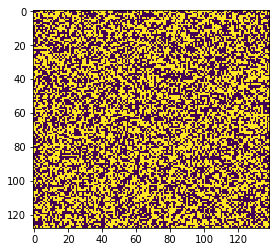

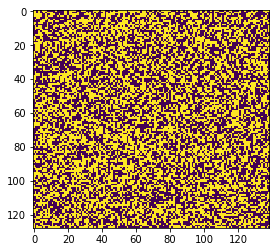

In [7]:
CLFss = ['Desicion Tree' ,'K Neighrest Neighbour Classifier']
CLFs = {'DST':DST(),'KNNC':KNNC(),}
gene = [None for i in range(len(CLFs))]
reduced_feature = [None for i in range(len(CLFs))]
for i_CLF in range(len(CLFs)):
    print(' ***************Trainig for classifier {} is started ******************'.format(CLFss[i_CLF]))
    gene[i_CLF] = genetic(train,Generation=13,Penalty_rate=1.0,classifier=list(CLFs.values())[i_CLF])
    gene[i_CLF].Generate()
    reduced_feature[i_CLF] = gene[i_CLF].train()

Features 

In [11]:
for i_CLF in range(len(CLFss)):
    print("Found Feature for {}".format(CLFss[i_CLF]),gene[i_CLF].society[0,0].sum())

Found Feature for Desicion Tree 8783
Found Feature for K Neighrest Neighbour Classifier 8913


In [12]:
def DST_hyper(i):
    selected_feature = np.nonzero(reduced_feature[i]);
    New_validation = validation.iloc[:,selected_feature[0]]
    New_train = train.iloc[:,selected_feature[0]]
    result = np.zeros((0,4))
    label_train = train['class']
    label_validation = validation['class']
    criterion = ['gini','entropy']
    depth = [2,5,100,1000,2000,5000,None]
    result_f1 = np.zeros((0,4))
    for i_criterion in range(len(criterion)):
        for i_depth in range(len(depth)):
            Model = DST(criterion=criterion[i_criterion],
                        max_depth = depth[i_depth],)
            Model.fit(New_train, label_train.values.ravel());
            Prediction = Model.predict(New_validation)
            accuracy = accuracy_score(Prediction,label_validation.values.ravel())
            result = np.vstack((result,(Model,
                                                criterion[i_criterion],
                                                depth[i_depth],
                                                accuracy)))
    
    return result[np.argmax(result[:,3]),0]

In [13]:
def KNN_hyper(i):
    selected_feature = np.nonzero(reduced_feature[i]);
    New_validation = validation.iloc[:,selected_feature[0]]
    New_train = train.iloc[:,selected_feature[0]]

    label_train = train['class']
    label_validation = validation['class']
    
    metric = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2','manhattan']
    algorithm = ['auto','ball_tree', 'kd_tree', 'brute']
    
    result = np.zeros((0,4))
    for i_metric in range(len(metric)):
        for i_algorithm in range(len(algorithm)):
            try:
                Model = KNNC(algorithm= algorithm[i_algorithm],
                            metric = metric[i_metric])
                Model.fit(New_train, label_train.values.ravel());
                Prediction = Model.predict(New_validation)
                accuracy = accuracy_score(Prediction,label_validation.values.ravel())
                result = np.vstack((result,(Model,
                                                metric[i_metric],
                                                algorithm[i_algorithm],
                                                accuracy)))
            except:
                pass
    
    return result[np.argmax(result[:,3]),0]

In [14]:
KNNC_model = KNN_hyper(0)

print(KNNC_model.score(test.ix[:,reduced_feature[0] == 1],test.ix[:, test.columns == 'class']))

pred_KNNC = KNNC_model.predict(test.ix[:,reduced_feature[0] == 1])

### Percision

label_test = np.asanyarray(label_test)
TP = np.sum(pred_DST== label_test)
FP = np.sum(label_test[np.where(label_test == 'Neg')[0]] != \
            pred_KNNC[np.where(label_test == 'Neg')[0]])
Precision = np.float(TP) / (np.float(TP) + np.float(FP))

print("Precision = ",Precision)

### Recal

FN = np.sum(np.not_equal(
                            label_test[np.where(label_test == 'Pos')[0]],
                            pred_KNNC[np.where(label_test == 'Pos')[0]]))
Recal = np.float(TP) / (np.float(TP) + np.float(FN))

print("Recal = ",Recal)

0.822857142857
Precision =  0.9032258064516129
Recal =  0.9333333333333333


In [15]:
DST_model = DST_hyper(1)

print(DST_model.score(test.ix[:,reduced_feature[1] == 1],test.ix[:, test.columns == 'class']))

pred_DST = DST_model.predict(test.ix[:,reduced_feature[1] == 1])
### Percision

label_test = np.asanyarray(label_test)
TP = np.sum(pred_DST== label_test)
FP = np.sum(label_test[np.where(label_test == 'Neg')[0]] != \
            pred_DST[np.where(label_test == 'Neg')[0]])
Precision = np.float(TP) / (np.float(TP) + np.float(FP))

print("Precision = ",Precision)

### Recal

FN = np.sum(np.not_equal(
                            label_test[np.where(label_test == 'Pos')[0]],
                            pred_DST[np.where(label_test == 'Pos')[0]]))
Recal = np.float(TP) / (np.float(TP) + np.float(FN))

print("Recal = ",Recal)

0.628571428571
Precision =  0.8111731843575419
Recal =  0.8746987951807229
